In [1]:
# === 단계 1: 환경 설정 및 라이브러리 임포트 ===

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [2]:
# === 데이터 로드 ===

# 기존 경로 사용
path_to_file = "/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/Go01/nsmc/ratings.txt"

print("NSMC 데이터 로드 중...")

with open(path_to_file, "r", encoding="utf-8") as f:
    raw = f.read().splitlines()

print(f"전체 데이터 크기: {len(raw)}")
print("\n데이터 구조 확인:")
print(f"헤더: {raw[0]}")
print("\n첫 5개 샘플:")
for i in range(1, 6):
    print(f"{i}: {raw[i]}")

NSMC 데이터 로드 중...
전체 데이터 크기: 200001

데이터 구조 확인:
헤더: id	document	label

첫 5개 샘플:
1: 8112052	어릴때보고 지금다시봐도 재밌어요ㅋㅋ	1
2: 8132799	디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.	1
3: 4655635	폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.	1
4: 9251303	와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지	1
5: 10067386	안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.	1


In [3]:
# === 기본 데이터 검증 ===

print("=== 데이터 품질 확인 ===")

# 데이터 파싱 테스트
valid_count = 0
invalid_count = 0
label_counts = {'0': 0, '1': 0}

for i, line in enumerate(raw[1:], 1):  # 헤더 제외
    try:
        parts = line.split('\t')
        if len(parts) >= 3:
            id_field = parts[0]
            document = parts[1]
            label = parts[2].strip()
            
            if label in ['0', '1'] and document.strip():
                valid_count += 1
                label_counts[label] += 1
            else:
                invalid_count += 1
        else:
            invalid_count += 1
            
        # 진행상황 출력 (10만개마다)
        if i % 100000 == 0:
            print(f"처리 중: {i}개 완료")
            
    except Exception as e:
        invalid_count += 1
        if invalid_count <= 5:  # 처음 몇 개 오류만 출력
            print(f"파싱 오류 (줄 {i}): {e}")

print(f"\n=== 데이터 요약 ===")
print(f"유효한 데이터: {valid_count:,}개")
print(f"무효한 데이터: {invalid_count:,}개")
print(f"부정 리뷰 (0): {label_counts['0']:,}개")
print(f"긍정 리뷰 (1): {label_counts['1']:,}개")
print(f"전체 성공률: {valid_count/(valid_count+invalid_count)*100:.1f}%")

# 샘플 데이터 확인
print(f"\n=== 샘플 데이터 확인 ===")
sample_indices = [1, 50000, 100000, 150000]
for idx in sample_indices:
    if idx < len(raw):
        parts = raw[idx].split('\t')
        if len(parts) >= 3:
            print(f"인덱스 {idx}: 레이블={parts[2]}, 텍스트='{parts[1][:50]}...'")

=== 데이터 품질 확인 ===
처리 중: 100000개 완료
처리 중: 200000개 완료

=== 데이터 요약 ===
유효한 데이터: 199,992개
무효한 데이터: 8개
부정 리뷰 (0): 99,996개
긍정 리뷰 (1): 99,996개
전체 성공률: 100.0%

=== 샘플 데이터 확인 ===
인덱스 1: 레이블=1, 텍스트='어릴때보고 지금다시봐도 재밌어요ㅋㅋ...'
인덱스 50000: 레이블=1, 텍스트='하균신 짱연기 쩔어!!...'
인덱스 100000: 레이블=1, 텍스트='파괴지왕에서 장학우 콘서트 티켓을 얻기위한... ㅋ...'
인덱스 150000: 레이블=0, 텍스트='분위기는 좋았는데, 중반 이후로 지루했다....'


In [4]:
# === 단계 2: 데이터 탐색 및 분석 ===

print("=== 문장 길이 및 품질 분석 ===")

texts = []
labels = []
lengths = []

# 유효한 데이터만 추출
for line in raw[1:]:  # 헤더 제외
    try:
        parts = line.split('\t')
        if len(parts) >= 3:
            text = parts[1].strip()
            label_str = parts[2].strip()
            
            if label_str in ['0', '1'] and text:
                texts.append(text)
                labels.append(int(label_str))
                lengths.append(len(text))
    except:
        continue

print(f"추출된 유효 데이터: {len(texts):,}개")

# 길이 통계
lengths_array = np.array(lengths)
print(f"\n=== 문장 길이 통계 ===")
print(f"최단 길이: {lengths_array.min()}")
print(f"최장 길이: {lengths_array.max()}")
print(f"평균 길이: {lengths_array.mean():.1f}")
print(f"중간값: {np.median(lengths_array):.1f}")
print(f"표준편차: {lengths_array.std():.1f}")

# 백분위수
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
print(f"\n=== 길이 백분위수 ===")
for p in percentiles:
    value = np.percentile(lengths_array, p)
    print(f"{p}%: {value:.0f}")

=== 문장 길이 및 품질 분석 ===
추출된 유효 데이터: 199,992개

=== 문장 길이 통계 ===
최단 길이: 1
최장 길이: 146
평균 길이: 35.2
중간값: 27.0
표준편차: 29.6

=== 길이 백분위수 ===
5%: 6
10%: 10
25%: 16
50%: 27
75%: 42
90%: 75
95%: 107
99%: 139


/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4514/3162925840.py:32: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_la

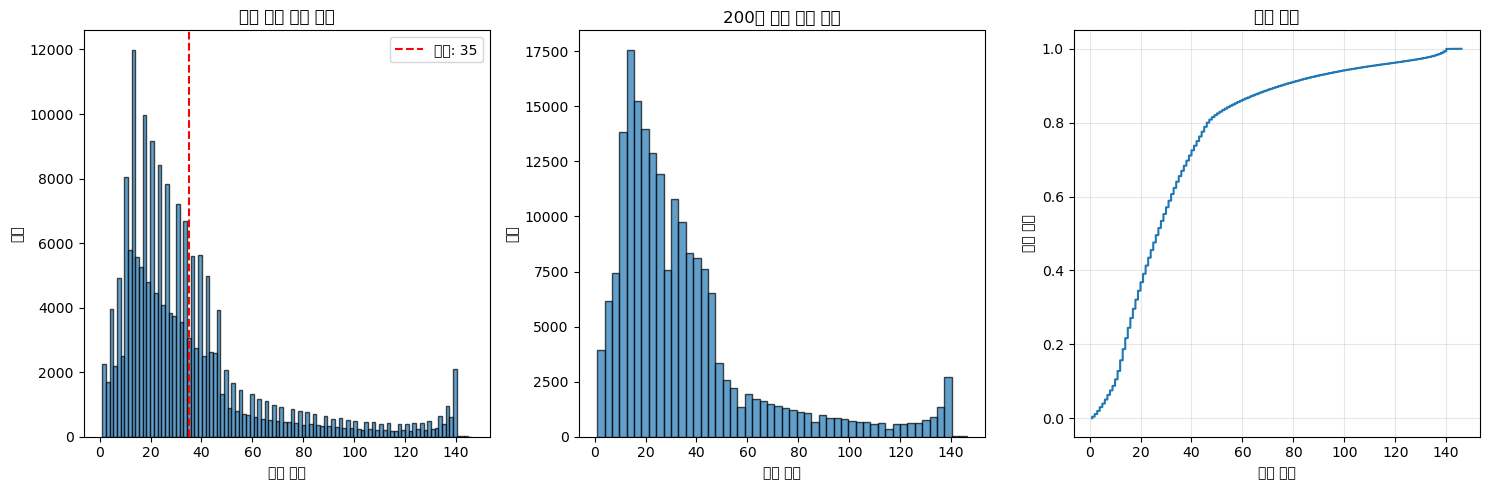


=== 극단적인 길이 샘플 확인 ===
가장 짧은 문장들:
1. 길이 1: '굳'
2. 길이 1: '.'
3. 길이 1: '올'
4. 길이 1: '짱'
5. 길이 1: '♥'

가장 긴 문장들:
1. 길이 144: '"중년부부 사이로 흐르는강 ""바라나시"" 관계와 죽음, 그안에 빠져 흘러가는강. '인간의 위선' 현실이다. 남편의 위선 위에 위선. 쿨한척 뒤엔 아내의 영역 침범 욕구를 보이는 ...'
2. 길이 144: '"보는 내내 짜증나는 영화.주제는 묵직하고 섬세한 표현력이 요구되는데 그저 시종일관 감성팔이. 억지로 슬프라고 강요하는거 같았다. 그와중에 동호가 ""아저씨 살려주세여""라고 외치...'
3. 길이 146: '"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는...'
4. 길이 146: '"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화...'
5. 길이 146: '"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에...'


In [5]:
# === 길이 분포 시각화 ===

plt.figure(figsize=(15, 5))

# 전체 분포
plt.subplot(1, 3, 1)
plt.hist(lengths, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('전체 문장 길이 분포')
plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'평균: {np.mean(lengths):.0f}')
plt.legend()

# 200자 이하만 확대
plt.subplot(1, 3, 2)
lengths_short = [l for l in lengths if l <= 200]
plt.hist(lengths_short, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('200자 이하 문장 분포')

# 누적 분포
plt.subplot(1, 3, 3)
sorted_lengths = np.sort(lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cumulative)
plt.xlabel('문장 길이')
plt.ylabel('누적 비율')
plt.title('누적 분포')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 극단적인 길이의 샘플들 확인
print("\n=== 극단적인 길이 샘플 확인 ===")
print("가장 짧은 문장들:")
short_indices = np.argsort(lengths)[:5]
for i, idx in enumerate(short_indices):
    print(f"{i+1}. 길이 {lengths[idx]}: '{texts[idx]}'")

print("\n가장 긴 문장들:")
long_indices = np.argsort(lengths)[-5:]
for i, idx in enumerate(long_indices):
    print(f"{i+1}. 길이 {lengths[idx]}: '{texts[idx][:100]}...'")

In [6]:
# === 중복 제거 및 품질 필터링 ===

print("=== 데이터 정제 시작 ===")
original_count = len(texts)

# 1. 중복 제거 (텍스트 기준)
print("1. 중복 문장 제거 중...")
seen_texts = set()
unique_texts = []
unique_labels = []

for text, label in zip(texts, labels):
    if text not in seen_texts:
        seen_texts.add(text)
        unique_texts.append(text)
        unique_labels.append(label)

duplicate_count = original_count - len(unique_texts)
print(f"   중복 제거: {duplicate_count:,}개 ({duplicate_count/original_count*100:.1f}%)")

# 2. 길이 기준 필터링 (10자 이상 200자 이하)
print("2. 길이 기준 필터링 중...")
MIN_LENGTH = 10
MAX_LENGTH = 150

filtered_texts = []
filtered_labels = []

for text, label in zip(unique_texts, unique_labels):
    if MIN_LENGTH <= len(text) <= MAX_LENGTH:
        filtered_texts.append(text)
        filtered_labels.append(label)

length_filtered = len(unique_texts) - len(filtered_texts)
print(f"   길이 필터링 제거: {length_filtered:,}개")
print(f"   (10자 미만 또는 200자 초과)")

# 3. 내용 품질 필터링
print("3. 내용 품질 필터링 중...")
quality_texts = []
quality_labels = []

for text, label in zip(filtered_texts, filtered_labels):
    # 의미있는 한글이 포함되어야 함
    korean_chars = len(re.findall(r'[가-힣]', text))
    if korean_chars >= 3:  # 최소 한글 3자 이상
        # 특수문자만으로 이루어진 문장 제외
        clean_text = re.sub(r'[^\w\s가-힣]', '', text)
        if len(clean_text.strip()) >= 5:
            quality_texts.append(text)
            quality_labels.append(label)

quality_filtered = len(filtered_texts) - len(quality_texts)
print(f"   품질 필터링 제거: {quality_filtered:,}개")

# 최종 결과
final_count = len(quality_texts)
total_removed = original_count - final_count
print(f"\n=== 정제 결과 ===")
print(f"원본 데이터: {original_count:,}개")
print(f"최종 데이터: {final_count:,}개")
print(f"제거된 데이터: {total_removed:,}개 ({total_removed/original_count*100:.1f}%)")

# 레이블 분포 확인
label_counts = Counter(quality_labels)
print(f"\n최종 레이블 분포:")
print(f"부정 (0): {label_counts[0]:,}개 ({label_counts[0]/final_count*100:.1f}%)")
print(f"긍정 (1): {label_counts[1]:,}개 ({label_counts[1]/final_count*100:.1f}%)")

# 정제된 데이터를 전역 변수로 저장
cleaned_texts = quality_texts
cleaned_labels = quality_labels

=== 데이터 정제 시작 ===
1. 중복 문장 제거 중...
   중복 제거: 5,449개 (2.7%)
2. 길이 기준 필터링 중...
   길이 필터링 제거: 12,845개
   (10자 미만 또는 200자 초과)
3. 내용 품질 필터링 중...
   품질 필터링 제거: 1,285개

=== 정제 결과 ===
원본 데이터: 199,992개
최종 데이터: 180,413개
제거된 데이터: 19,579개 (9.8%)

최종 레이블 분포:
부정 (0): 90,328개 (50.1%)
긍정 (1): 90,085개 (49.9%)


In [7]:
# 새로운 길이 분포
new_lengths = [len(text) for text in cleaned_texts]
new_lengths_array = np.array(new_lengths)

print(f"정제 후 길이 통계:")
print(f"최단: {new_lengths_array.min()}, 최장: {new_lengths_array.max()}")
print(f"평균: {new_lengths_array.mean():.1f}, 중간값: {np.median(new_lengths_array):.1f}")

# 샘플 확인
print(f"\n=== 정제된 데이터 샘플 ===")
sample_indices = np.random.choice(len(cleaned_texts), 10, replace=False)
for i, idx in enumerate(sample_indices):
    label_name = "긍정" if cleaned_labels[idx] == 1 else "부정"
    print(f"{i+1}. [{label_name}] {cleaned_texts[idx]}")

정제 후 길이 통계:
최단: 10, 최장: 146
평균: 38.3, 중간값: 29.0

=== 정제된 데이터 샘플 ===
1. [긍정] 행복한 웃음을 자아내는 영화. 끝나고 실화라고 나와서 적잖이 놀랬다
2. [부정] 짜증나게 헤서웨이의 작품보는눈은 낮아져만 간다
3. [부정] 아나 댓글이 더웃겨 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
4. [부정] 어설픈 흉내내기에 불과한 성급한 리부트
5. [긍정] 비디오테이프 돌려보던시절, 잔잔한 감동 , 풋풋한 청춘으로 돌아가 그림에서 사람이 뛰어나올거 같은 영상은 지금도 잊혀지지가 않는다,,천국보다 아름다운 세상이 과연 잇을|까.. 로빈윌리엄스님 좋은 작품 너무나 감사합니다.
6. [긍정] 이정도면 평점 만점받을 영화인데 다들 왜이러시나-_-..
7. [부정] 스타워즈의 츄파가 기억났다
8. [부정] 연극인줄...연극스타일 연출과 대사...차라리 좋은 연극 연출가가 연극으로 각색하는게 나을듯..
9. [긍정] 엇갈린 사랑 해보신 분들께 추천 합니다.
10. [긍정] 너무 재미지다ㅎㅎ소장용


In [8]:
# === 단계 3: SentencePiece 토크나이저 클래스 구현 ===

import sentencepiece as spm
import os
import re

class NSMCSentencePieceTokenizer:
    def __init__(self, vocab_size=15000, model_type='bpe', model_prefix='nsmc_sp'):
        """
        NSMC 데이터를 위한 SentencePiece 토크나이저
        
        Args:
            vocab_size: 어휘 크기 (기본값: 20000)
            model_type: 'bpe' 또는 'unigram' (기본값: 'bpe')
            model_prefix: 모델 파일 접두사 (기본값: 'nsmc_sp')
        """
        self.vocab_size = vocab_size
        self.model_type = model_type
        self.model_prefix = model_prefix
        self.model_path = f"{model_prefix}.model"
        self.vocab_path = f"{model_prefix}.vocab"
        self.sp = None
        
        print(f"SentencePiece 토크나이저 초기화")
        print(f"- 어휘 크기: {vocab_size}")
        print(f"- 모델 타입: {model_type}")
        print(f"- 모델 파일: {self.model_path}")
        
    def preprocess_text(self, text):
        """
        한국어 영화 리뷰에 특화된 텍스트 전처리
        """
        if not text or not isinstance(text, str):
            return ""
        
        # 기본 정리
        text = text.strip()
        
        # 반복되는 특수 문자 정규화
        text = re.sub(r'[ㅋㅋ]+', ' ㅋㅋ ', text)  # 웃음 표현
        text = re.sub(r'[ㅠㅜ]+', ' ㅠㅠ ', text)  # 울음 표현  
        text = re.sub(r'!{2,}', '!', text)        # 반복 느낌표
        text = re.sub(r'\?{2,}', '?', text)       # 반복 물음표
        text = re.sub(r'\.{3,}', '...', text)     # 반복 점
        
        # 이모티콘 및 특수문자 처리
        text = re.sub(r'[^\w\s가-힣ㅋㅠㅜ.,!?~\-]', ' ', text)
        
        # 연속된 공백 제거
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def prepare_corpus_for_training(self, texts):
        """
        SentencePiece 학습을 위한 코퍼스 준비
        
        Args:
            texts: 텍스트 리스트
            
        Returns:
            processed_texts: 전처리된 텍스트 리스트
        """
        print("코퍼스 전처리 중...")
        
        processed_texts = []
        skipped_count = 0
        
        for i, text in enumerate(texts):
            processed_text = self.preprocess_text(text)
            
            # 전처리 후에도 의미있는 내용이 남아있는지 확인
            if processed_text and len(processed_text) >= 5:
                processed_texts.append(processed_text)
            else:
                skipped_count += 1
            
            # 진행상황 출력
            if (i + 1) % 50000 == 0:
                print(f"  {i + 1:,}개 처리 완료")
        
        print(f"전처리 완료:")
        print(f"- 처리된 텍스트: {len(processed_texts):,}개")
        print(f"- 건너뛴 텍스트: {skipped_count:,}개")
        
        return processed_texts
    
    def train_sentencepiece(self, texts, sample_size=None):
        """
        SentencePiece 모델 학습
        
        Args:
            texts: 학습용 텍스트 리스트
            sample_size: 샘플링할 텍스트 수 (None이면 전체 사용)
        """
        # 샘플링 (메모리 및 시간 절약)
        if sample_size and len(texts) > sample_size:
            import random
            random.seed(42)
            texts = random.sample(texts, sample_size)
            print(f"학습용 데이터 샘플링: {sample_size:,}개")
        
        print(f"SentencePiece 모델 학습 시작")
        print(f"- 학습 데이터: {len(texts):,}개")
        print(f"- 어휘 크기: {self.vocab_size}")
        
        # 학습용 임시 파일 생성
        train_file = f"{self.model_prefix}_train.txt"
        
        with open(train_file, 'w', encoding='utf-8') as f:
            for text in texts:
                f.write(text + '\n')
        
        # SentencePiece 모델 학습
        try:
            spm.SentencePieceTrainer.train(
                input=train_file,
                model_prefix=self.model_prefix,
                vocab_size=self.vocab_size,
                model_type=self.model_type,
                character_coverage=0.9995,  # 한국어에 적합한 설정
                pad_id=0,     # <pad> 토큰
                unk_id=1,     # <unk> 토큰  
                bos_id=2,     # <s> 토큰
                eos_id=3,     # </s> 토큰
                user_defined_symbols=['<mask>'],  # 추가 특수 토큰
                max_sentence_length=512,
                shuffle_input_sentence=True,
                split_by_whitespace=True,
            )
            
            print(f"SentencePiece 모델 학습 완료!")
            print(f"- 모델 파일: {self.model_path}")
            print(f"- 어휘 파일: {self.vocab_path}")
            
        except Exception as e:
            print(f"모델 학습 중 오류 발생: {e}")
            raise
        
        finally:
            # 임시 파일 정리
            if os.path.exists(train_file):
                os.remove(train_file)
        
    def load_model(self):
        """
        학습된 SentencePiece 모델 로드
        """
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {self.model_path}")
        
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(self.model_path)
        
        print(f"SentencePiece 모델 로드 완료")
        print(f"- 실제 어휘 크기: {self.sp.vocab_size()}")
        
        # 특수 토큰 확인
        special_tokens = {
            'pad': self.sp.id_to_piece(0),
            'unk': self.sp.id_to_piece(1), 
            'bos': self.sp.id_to_piece(2),
            'eos': self.sp.id_to_piece(3)
        }
        print(f"- 특수 토큰: {special_tokens}")
    
    def encode(self, texts, add_bos=True, add_eos=True):
        """
        텍스트를 토큰 ID로 인코딩
        
        Args:
            texts: 인코딩할 텍스트 (문자열 또는 리스트)
            add_bos: BOS 토큰 추가 여부
            add_eos: EOS 토큰 추가 여부
            
        Returns:
            sequences: 토큰 ID 시퀀스 리스트 (torch.Tensor)
        """
        if self.sp is None:
            self.load_model()
        
        if isinstance(texts, str):
            texts = [texts]
        
        sequences = []
        for text in texts:
            processed_text = self.preprocess_text(text)
            if processed_text:
                ids = self.sp.encode(processed_text, add_bos=add_bos, add_eos=add_eos)
                sequences.append(torch.tensor(ids, dtype=torch.long))
            else:
                # 빈 텍스트인 경우 UNK 토큰만
                ids = [1]  # UNK token
                if add_bos:
                    ids = [2] + ids  # BOS + UNK
                if add_eos:
                    ids = ids + [3]  # + EOS
                sequences.append(torch.tensor(ids, dtype=torch.long))
        
        return sequences
    
    def decode(self, sequences):
        """
        토큰 ID를 텍스트로 디코딩
        
        Args:
            sequences: 토큰 ID 시퀀스 리스트
            
        Returns:
            texts: 디코딩된 텍스트 리스트
        """
        if self.sp is None:
            self.load_model()
        
        texts = []
        for seq in sequences:
            if isinstance(seq, torch.Tensor):
                seq = seq.tolist()
            
            # 패딩 토큰(0) 제거
            seq = [id for id in seq if id != 0]
            
            if seq:
                text = self.sp.decode(seq)
                texts.append(text)
            else:
                texts.append("")
        
        return texts
    
    def encode_as_pieces(self, texts):
        """
        텍스트를 서브워드 조각으로 인코딩
        
        Args:
            texts: 인코딩할 텍스트 (문자열 또는 리스트)
            
        Returns:
            pieces_list: 서브워드 조각 리스트
        """
        if self.sp is None:
            self.load_model()
        
        if isinstance(texts, str):
            texts = [texts]
        
        pieces_list = []
        for text in texts:
            processed_text = self.preprocess_text(text)
            if processed_text:
                pieces = self.sp.encode_as_pieces(processed_text)
                pieces_list.append(pieces)
            else:
                pieces_list.append(['<unk>'])
        
        return pieces_list
    
    def get_vocab_size(self):
        """어휘 크기 반환"""
        if self.sp is None:
            self.load_model()
        return self.sp.vocab_size()
    
    def get_pad_id(self):
        """패딩 토큰 ID 반환"""
        return 0
    
    def get_special_tokens_dict(self):
        """특수 토큰 딕셔너리 반환"""
        return {
            'pad_token': '<pad>',
            'unk_token': '<unk>',
            'bos_token': '<s>',
            'eos_token': '</s>',
            'pad_token_id': 0,
            'unk_token_id': 1,
            'bos_token_id': 2,
            'eos_token_id': 3,
        }

In [9]:
# === 토크나이저 인스턴스 생성 ===

print("=== NSMC SentencePiece 토크나이저 생성 ===")

# 토크나이저 생성 (어휘 크기 10000으로 시작)
tokenizer = NSMCSentencePieceTokenizer(vocab_size=15000,model_type='bpe',model_prefix='nsmc_sp')

=== NSMC SentencePiece 토크나이저 생성 ===
SentencePiece 토크나이저 초기화
- 어휘 크기: 15000
- 모델 타입: bpe
- 모델 파일: nsmc_sp.model


In [11]:
print("=== SentencePiece 토크나이저 학습 시작 ===")

# 학습용 코퍼스 준비
print("1. 학습용 코퍼스 준비 중...")
training_corpus = tokenizer.prepare_corpus_for_training(cleaned_texts)

# 메모리 절약을 위해 샘플링 (전체 데이터가 많은 경우)
sample_size = min(30000, len(training_corpus))
print(f"2. 학습 데이터 크기 조정: {len(training_corpus):,} -> {sample_size:,}")

# SentencePiece 모델 학습
print("3. SentencePiece 모델 학습")
tokenizer.train_sentencepiece(training_corpus, sample_size=sample_size)

# 학습된 모델 로드
print("4. 학습된 모델 로드")
tokenizer.load_model()

print("토크나이저 학습 및 로드 완료")

=== SentencePiece 토크나이저 학습 시작 ===
1. 학습용 코퍼스 준비 중...
코퍼스 전처리 중...
  50,000개 처리 완료
  100,000개 처리 완료
  150,000개 처리 완료
전처리 완료:
- 처리된 텍스트: 180,413개
- 건너뛴 텍스트: 0개
2. 학습 데이터 크기 조정: 180,413 -> 30,000
3. SentencePiece 모델 학습
학습용 데이터 샘플링: 30,000개
SentencePiece 모델 학습 시작
- 학습 데이터: 30,000개
- 어휘 크기: 15000
SentencePiece 모델 학습 완료!
- 모델 파일: nsmc_sp.model
- 어휘 파일: nsmc_sp.vocab
4. 학습된 모델 로드
SentencePiece 모델 로드 완료
- 실제 어휘 크기: 15000
- 특수 토큰: {'pad': '<pad>', 'unk': '<unk>', 'bos': '<s>', 'eos': '</s>'}
토크나이저 학습 및 로드 완료


In [12]:
# === 토크나이저 기본 성능 테스트 ===

print("=== 토크나이징 성능 테스트 ===")

# 테스트용 샘플 문장들 (다양한 특성)
test_sentences = [
    "이 영화 정말 재밌어요!",
    "배우들의 연기가 너무 좋았습니다.",
    "스토리가 지루하고 예측 가능해요 ㅠㅠ",
    "오랜만에 본 감동적인 한국 영화네요 ㅋㅋㅋ",
    "돈이 아까운 영화였습니다... 실망",
    "최고의 영화!!!! 다시 보고 싶어요",
    "액션 장면이 화려하고 스릴감 넘쳐요",
    "로맨스 영화인데 감동이 없네요",
    "코미디 요소가 적절히 섞여있어서 재밌었어요"
]

print("서브워드 토크나이징 결과:")
print("=" * 80)

for i, sentence in enumerate(test_sentences, 1):
    # 서브워드로 분할
    pieces = tokenizer.encode_as_pieces(sentence)
    
    # ID로 인코딩
    ids = tokenizer.encode(sentence, add_bos=True, add_eos=True)
    
    # 다시 디코딩
    decoded = tokenizer.decode(ids)
    
    print(f"{i}. 원문: {sentence}")
    print(f"   토큰: {pieces[0]}")
    print(f"   개수: {len(pieces[0])}개")
    print(f"   ID: {ids[0].tolist()}")
    print(f"   복원: {decoded[0]}")
    print("-" * 80)

=== 토크나이징 성능 테스트 ===
서브워드 토크나이징 결과:
1. 원문: 이 영화 정말 재밌어요!
   토큰: ['▁이', '▁영화', '▁정말', '▁재밌어요', '!']
   개수: 5개
   ID: [2, 8, 7, 46, 914, 13472, 3]
   복원: 이 영화 정말 재밌어요!
--------------------------------------------------------------------------------
2. 원문: 배우들의 연기가 너무 좋았습니다.
   토큰: ['▁배우들의', '▁연기가', '▁너무', '▁좋았습니다', '.']
   개수: 5개
   ID: [2, 892, 771, 29, 2004, 13409, 3]
   복원: 배우들의 연기가 너무 좋았습니다.
--------------------------------------------------------------------------------
3. 원문: 스토리가 지루하고 예측 가능해요 ㅠㅠ
   토큰: ['▁스토리가', '▁지루하고', '▁예측', '▁가능', '해요', '▁ᅲᅲ']
   개수: 6개
   ID: [2, 823, 888, 4946, 1898, 813, 67, 3]
   복원: 스토리가 지루하고 예측 가능해요 ᅲᅲ
--------------------------------------------------------------------------------
4. 원문: 오랜만에 본 감동적인 한국 영화네요 ㅋㅋㅋ
   토큰: ['▁오랜만에', '▁본', '▁감동적인', '▁한국', '▁영화네요', '▁ᄏᄏ']
   개수: 6개
   ID: [2, 977, 95, 1461, 239, 1130, 22, 3]
   복원: 오랜만에 본 감동적인 한국 영화네요 ᄏᄏ
--------------------------------------------------------------------------------
5. 원문: 돈이 아까운 영화였습니다... 실망

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class NSMCDataset(Dataset):
    """
    NSMC 감성분석을 위한 PyTorch Dataset 클래스
    SentencePiece 토크나이저와 연동
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=128, add_special_tokens=True):
        """
        Args:
            texts: 텍스트 리스트
            labels: 레이블 리스트 (0: 부정, 1: 긍정)
            tokenizer: SentencePiece 토크나이저
            max_length: 최대 시퀀스 길이
            add_special_tokens: BOS/EOS 토큰 추가 여부
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.add_special_tokens = add_special_tokens
        
        print(f"NSMCDataset 초기화:")
        print(f"- 데이터 수: {len(texts)}")
        print(f"- 최대 길이: {max_length}")
        print(f"- 특수 토큰 추가: {add_special_tokens}")
        
        # 레이블 분포 확인
        label_counts = Counter(labels)
        print(f"- 레이블 분포: 부정({label_counts[0]}) / 긍정({label_counts[1]})")
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        개별 아이템 반환
        
        Returns:
            dict: {
                'input_ids': 토큰 ID 텐서,
                'attention_mask': 어텐션 마스크,
                'labels': 레이블 텐서
            }
        """
        text = self.texts[idx]
        label = self.labels[idx]
        
        # 텍스트를 토큰 ID로 변환
        encoded = self.tokenizer.encode(
            text, 
            add_bos=self.add_special_tokens, 
            add_eos=self.add_special_tokens
        )
        tokens = encoded[0]  # 첫 번째 (유일한) 시퀀스
        
        # 길이 조정
        if len(tokens) > self.max_length:
            # 너무 긴 경우 자르기
            tokens = tokens[:self.max_length]
        else:
            # 짧은 경우 패딩 추가
            pad_length = self.max_length - len(tokens)
            padding = torch.full(
                (pad_length,), 
                self.tokenizer.get_pad_id(), 
                dtype=torch.long
            )
            tokens = torch.cat([tokens, padding])
        
        # 어텐션 마스크 생성 (실제 토큰은 1, 패딩은 0)
        attention_mask = (tokens != self.tokenizer.get_pad_id()).float()
        
        return {
            'input_ids': tokens,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    def get_sample_batch(self, batch_size=4):
        """
        샘플 배치 반환 (테스트용)
        """
        indices = np.random.choice(len(self), batch_size, replace=False)
        batch = [self[i] for i in indices]
        
        # 배치 구성
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask, 
            'labels': labels,
            'original_texts': [self.texts[i] for i in indices]
        }

In [14]:
# === 데이터셋 클래스 동작 테스트 ===

print("=== 데이터셋 동작 테스트 ===")

# 작은 샘플로 테스트 데이터셋 생성
test_texts = cleaned_texts[:1000]  # 처음 1000개
test_labels = cleaned_labels[:1000]

# 테스트 데이터셋 생성
test_dataset = NSMCDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=128,
    add_special_tokens=True
)

print(f"\n데이터셋 크기: {len(test_dataset)}")

# 개별 아이템 테스트
print("\n=== 개별 아이템 확인 ===")
sample_item = test_dataset[0]

print(f"첫 번째 아이템:")
print(f"- 원본 텍스트: '{test_texts[0]}'")
print(f"- 레이블: {test_labels[0]} ({'긍정' if test_labels[0] == 1 else '부정'})")
print(f"- input_ids 크기: {sample_item['input_ids'].shape}")
print(f"- attention_mask 크기: {sample_item['attention_mask'].shape}")
print(f"- 실제 토큰 수: {sample_item['attention_mask'].sum().item()}")
print(f"- input_ids: {sample_item['input_ids'][:20].tolist()}...")  # 처음 20개만

# 복원 테스트
decoded_text = tokenizer.decode([sample_item['input_ids']])[0]
print(f"- 복원된 텍스트: '{decoded_text}'")


=== 데이터셋 동작 테스트 ===
NSMCDataset 초기화:
- 데이터 수: 1000
- 최대 길이: 128
- 특수 토큰 추가: True
- 레이블 분포: 부정(0) / 긍정(1000)

데이터셋 크기: 1000

=== 개별 아이템 확인 ===
첫 번째 아이템:
- 원본 텍스트: '어릴때보고 지금다시봐도 재밌어요ㅋㅋ'
- 레이블: 1 (긍정)
- input_ids 크기: torch.Size([128])
- attention_mask 크기: torch.Size([128])
- 실제 토큰 수: 8.0
- input_ids: [2, 1747, 167, 233, 7941, 914, 22, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
- 복원된 텍스트: '어릴때보고 지금다시봐도 재밌어요 ᄏᄏ'


In [15]:
# === 배치 처리 및 DataLoader 테스트 ===

print("=== 배치 처리 테스트 ===")

# DataLoader 생성
test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=True,
    num_workers=0  # Windows 호환성
)

print(f"DataLoader 생성 완료:")
print(f"- 배치 크기: 8")
print(f"- 총 배치 수: {len(test_loader)}")

# 첫 번째 배치 확인
first_batch = next(iter(test_loader))

print(f"\n첫 번째 배치 구조:")
for key, value in first_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: {value.shape} {value.dtype}")
    else:
        print(f"- {key}: {type(value)} (길이: {len(value)})")

# 배치 내용 확인
print(f"\n배치 내용 샘플:")
for i in range(3):  # 처음 3개만
    orig_text = test_texts[test_loader.dataset.texts.index(test_texts[i])] if i < len(test_texts) else "N/A"
    label = first_batch['labels'][i].item()
    mask_sum = first_batch['attention_mask'][i].sum().item()
    
    print(f"{i+1}. 레이블: {label}, 실제 토큰 수: {mask_sum}")
    print(f"   원문: '{test_texts[i][:50]}...'")

# 메모리 효율성 확인
sample_batch = test_dataset.get_sample_batch(batch_size=4)
print(f"\n샘플 배치 테스트:")
print(f"- input_ids: {sample_batch['input_ids'].shape}")
print(f"- 메모리 사용량: {sample_batch['input_ids'].nelement() * sample_batch['input_ids'].element_size() / 1024:.1f} KB")

=== 배치 처리 테스트 ===
DataLoader 생성 완료:
- 배치 크기: 8
- 총 배치 수: 125

첫 번째 배치 구조:
- input_ids: torch.Size([8, 128]) torch.int64
- attention_mask: torch.Size([8, 128]) torch.float32
- labels: torch.Size([8]) torch.int64

배치 내용 샘플:
1. 레이블: 1, 실제 토큰 수: 18.0
   원문: '어릴때보고 지금다시봐도 재밌어요ㅋㅋ...'
2. 레이블: 1, 실제 토큰 수: 9.0
   원문: '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부...'
3. 레이블: 1, 실제 토큰 수: 29.0
   원문: '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고....'

샘플 배치 테스트:
- input_ids: torch.Size([4, 128])
- 메모리 사용량: 4.0 KB


In [16]:
class NSMCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoded = self.tokenizer.encode(text, add_bos=True, add_eos=True)
        tokens = encoded[0]
        
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            padding = torch.full((self.max_length - len(tokens),), 
                               self.tokenizer.get_pad_id(), dtype=torch.long)
            tokens = torch.cat([tokens, padding])
        
        attention_mask = (tokens != self.tokenizer.get_pad_id()).float()
        
        return {
            'input_ids': tokens,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=2, dropout=0.3):
        super(SentimentClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        embedded = self.dropout(embedded)
        
        lstm_output, (hidden, cell) = self.lstm(embedded)
        
        if attention_mask is not None:
            batch_size = lstm_output.size(0)
            seq_lengths = attention_mask.sum(dim=1).long() - 1
            last_outputs = []
            for i in range(batch_size):
                last_outputs.append(lstm_output[i, seq_lengths[i], :])
            features = torch.stack(last_outputs)
        else:
            features = lstm_output[:, -1, :]
        
        logits = self.classifier(features)
        return logits

In [17]:
import random

def prepare_balanced_data(raw_data, max_samples=50000):
    """균형잡힌 데이터 준비"""
    
    # 전체 데이터에서 텍스트와 레이블 추출
    all_texts = []
    all_labels = []
    
    print("전체 데이터 파싱 중...")
    for line in raw_data[1:]:  # 헤더 제외
        parts = line.split('\t')
        if len(parts) >= 3:
            text = parts[1].strip()
            label_str = parts[2].strip()
            
            if label_str in ['0', '1'] and text and len(text) > 10:
                all_texts.append(text)
                all_labels.append(int(label_str))
    
    print(f"전체 파싱된 데이터: {len(all_texts)}개")
    
    # 긍정/부정 분리
    positive_data = [(text, label) for text, label in zip(all_texts, all_labels) if label == 1]
    negative_data = [(text, label) for text, label in zip(all_texts, all_labels) if label == 0]
    
    print(f"긍정 데이터: {len(positive_data)}개")
    print(f"부정 데이터: {len(negative_data)}개")
    
    # 균형잡힌 샘플링
    samples_per_class = min(max_samples // 2, len(positive_data), len(negative_data))
    
    # 랜덤 샘플링
    random.seed(42)
    selected_positive = random.sample(positive_data, samples_per_class)
    selected_negative = random.sample(negative_data, samples_per_class)
    
    # 결합 및 셔플
    combined_data = selected_positive + selected_negative
    random.shuffle(combined_data)
    
    # 텍스트와 레이블 분리
    final_texts = [item[0] for item in combined_data]
    final_labels = [item[1] for item in combined_data]
    
    return final_texts, final_labels

# 균형잡힌 데이터 준비
print("=== 균형잡힌 데이터 준비 ===")
texts, labels = prepare_balanced_data(raw, max_samples=50000)

print(f"\n최종 결과:")
print(f"- 총 데이터 수: {len(texts)}")
print(f"- 긍정 샘플 (1): {sum(labels)}")
print(f"- 부정 샘플 (0): {len(labels) - sum(labels)}")
print(f"- 긍정 비율: {sum(labels)/len(labels):.2%}")

# 샘플 확인
print(f"\n샘플 확인:")
for i in range(5):
    print(f"샘플 {i+1}: 레이블={labels[i]}, 텍스트='{texts[i][:50]}...'")

=== 균형잡힌 데이터 준비 ===
전체 데이터 파싱 중...
전체 파싱된 데이터: 178979개
긍정 데이터: 89334개
부정 데이터: 89645개

최종 결과:
- 총 데이터 수: 50000
- 긍정 샘플 (1): 25000
- 부정 샘플 (0): 25000
- 긍정 비율: 50.00%

샘플 확인:
샘플 1: 레이블=0, 텍스트='이 영화가 흥행한뒤로 남은게 뭐가있는가??...'
샘플 2: 레이블=1, 텍스트='비디오드롬 이후의 또 하나의 오묘한 영화...'
샘플 3: 레이블=1, 텍스트='채널CGV에서 이 영화봤는데..와..고등학교때 짝사랑했던 친구가 생각나던..막 설레이네.....'
샘플 4: 레이블=1, 텍스트='원작의 갈등과 감동을 잘 뽑아낸 좋은작품. 여자라면 공감90%이상...'
샘플 5: 레이블=1, 텍스트='오랜만이다. 정말 3편까진 그나마 참아줬지만 이미 4편부턴 '무서운 영화' 수준...'


In [18]:
from sklearn.model_selection import train_test_split

print("=== 데이터셋 및 데이터로더 생성 ===")

# 이미 준비된 texts, labels 사용 (데이터 추출 부분 제거)
print(f"사용할 데이터: {len(texts)}개")
print(f"긍정: {sum(labels)}개, 부정: {len(labels) - sum(labels)}개")

# 훈련/검증 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"훈련 데이터: {len(train_texts)}개")
print(f"검증 데이터: {len(val_texts)}개")

# 데이터셋 생성
train_dataset = NSMCDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = NSMCDataset(val_texts, val_labels, tokenizer, max_length=128)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

=== 데이터셋 및 데이터로더 생성 ===
사용할 데이터: 50000개
긍정: 25000개, 부정: 25000개
훈련 데이터: 40000개
검증 데이터: 10000개


In [19]:
# === 단계 9: 모델 훈련 파이프라인 구현 ===

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """
    한 에포크 훈련 수행
    
    Returns:
        avg_loss: 평균 손실값
        accuracy: 훈련 정확도
    """
    model.train()
    
    epoch_losses = []
    all_predictions = []
    all_labels = []
    
    batch_count = 0
    
    for batch in dataloader:
        # 데이터를 디바이스로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # 그라디언트 초기화
        optimizer.zero_grad()
        
        # 순전파
        logits = model(input_ids, attention_mask)
        
        # 손실 계산
        loss = criterion(logits, labels)
        
        # 역전파
        loss.backward()
        
        # 그라디언트 클리핑 (안정성 향상)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # 가중치 업데이트
        optimizer.step()
        
        # 결과 저장
        epoch_losses.append(loss.item())
        
        # 예측값 계산
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        batch_count += 1
        
        # 진행상황 출력 (20% 단위)
        if batch_count % (len(dataloader) // 5) == 0:
            current_acc = accuracy_score(all_labels, all_predictions)
            print(f"    배치 {batch_count}/{len(dataloader)} - "
                  f"Loss: {loss.item():.4f}, Acc: {current_acc:.4f}")
    
    # 에포크 결과 계산
    avg_loss = np.mean(epoch_losses)
    final_accuracy = accuracy_score(all_labels, all_predictions)
    
    return avg_loss, final_accuracy

def validate_model(model, dataloader, criterion, device):
    """
    모델 검증 수행
    
    Returns:
        avg_loss: 평균 손실값
        accuracy: 검증 정확도
        predictions: 예측 결과
        true_labels: 실제 레이블
    """
    model.eval()
    
    val_losses = []
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # 순전파만 수행
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # 결과 저장
            val_losses.append(loss.item())
            
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 검증 결과 계산
    avg_loss = np.mean(val_losses)
    accuracy = accuracy_score(all_labels, all_predictions)
    
    return avg_loss, accuracy, all_predictions, all_labels

print("훈련 및 검증 함수 정의 완료!")

훈련 및 검증 함수 정의 완료!


In [22]:
# === 메인 훈련 파이프라인 ===

def run_training_pipeline(train_dataset, val_dataset, 
                         vocab_size, epochs=10, batch_size=32, learning_rate=3e-4):
    """
    전체 훈련 파이프라인 실행
    
    Args:
        train_dataset: 훈련 데이터셋
        val_dataset: 검증 데이터셋
        vocab_size: 어휘 크기
        epochs: 에포크 수
        batch_size: 배치 크기
        learning_rate: 학습률
        
    Returns:
        trained_model: 훈련된 모델
        best_val_acc: 최고 검증 정확도
        history: 훈련 히스토리
    """
    
    print(f"=== 훈련 파이프라인 시작 ===")
    print(f"- 훈련 데이터: {len(train_dataset)}")
    print(f"- 검증 데이터: {len(val_dataset)}")
    print(f"- 에포크: {epochs}")
    print(f"- 배치 크기: {batch_size}")
    print(f"- 학습률: {learning_rate}")
    
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"- 사용 디바이스: {device}")
    
    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 모델 초기화
    model = SentimentClassifier(
        vocab_size=vocab_size,
        embedding_dim=256,      # 임베딩 차원 증가
        hidden_dim=384,         # 히든 차원 적당한 크기
        num_classes=2,
        dropout=0.2             # 드롭아웃 감소
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"- 모델 파라미터 수: {total_params:,}")
    
    # 옵티마이저 및 손실함수
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    # 학습률 스케줄러
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    # 훈련 기록 저장
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    patience_limit = 7
    
    print(f"\n=== 훈련 시작 ===")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # 훈련
        print("훈련 중...")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        # 검증
        print("검증 중...")
        val_loss, val_acc, val_preds, val_true = validate_model(model, val_loader, criterion, device)
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 현재 학습률 확인
        current_lr = optimizer.param_groups[0]['lr']
        
        # 결과 출력
        print(f"\n에포크 {epoch+1} 결과:")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_acc': val_acc,
                'vocab_size': vocab_size
            }, 'best_nsmc_model.pt')
            print(f"  ✓ 새로운 최고 성능! 모델 저장 (Val Acc: {val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # 학습률 조정
        scheduler.step(val_acc)
        
        # 조기 종료 확인
        if patience_counter >= patience_limit:
            print(f"\n조기 종료: {patience_limit} 에포크 동안 개선 없음")
            break
    
    print(f"\n=== 훈련 완료 ===")
    print(f"최고 검증 정확도: {best_val_acc:.4f} ({best_val_acc:.1%})")
    
    return model, best_val_acc, history

print("훈련 파이프라인 함수 정의 완료!")

훈련 파이프라인 함수 정의 완료!


=== 모델 훈련 실행 ===
=== 훈련 파이프라인 시작 ===
- 훈련 데이터: 40000
- 검증 데이터: 10000
- 에포크: 5
- 배치 크기: 32
- 학습률: 0.0003
- 사용 디바이스: cuda
- 모델 파라미터 수: 6,108,290

=== 훈련 시작 ===

Epoch 1/5
--------------------------------------------------
훈련 중...


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


    배치 250/1250 - Loss: 0.6089, Acc: 0.5867
    배치 500/1250 - Loss: 0.6704, Acc: 0.6201
    배치 750/1250 - Loss: 0.5281, Acc: 0.6416
    배치 1000/1250 - Loss: 0.5031, Acc: 0.6573
    배치 1250/1250 - Loss: 0.6800, Acc: 0.6717
검증 중...

에포크 1 결과:
  Train - Loss: 0.5985, Acc: 0.6717
  Val   - Loss: 0.5067, Acc: 0.7511
  Learning Rate: 0.000300
  ✓ 새로운 최고 성능! 모델 저장 (Val Acc: 0.7511)

Epoch 2/5
--------------------------------------------------
훈련 중...
    배치 250/1250 - Loss: 0.3408, Acc: 0.7639
    배치 500/1250 - Loss: 0.4157, Acc: 0.7677
    배치 750/1250 - Loss: 0.2848, Acc: 0.7712
    배치 1000/1250 - Loss: 0.7361, Acc: 0.7746
    배치 1250/1250 - Loss: 0.3600, Acc: 0.7770
검증 중...

에포크 2 결과:
  Train - Loss: 0.4696, Acc: 0.7770
  Val   - Loss: 0.4581, Acc: 0.7868
  Learning Rate: 0.000300
  ✓ 새로운 최고 성능! 모델 저장 (Val Acc: 0.7868)

Epoch 3/5
--------------------------------------------------
훈련 중...
    배치 250/1250 - Loss: 0.2533, Acc: 0.8211
    배치 500/1250 - Loss: 0.4951, Acc: 0.8189
    배치 750/1250 

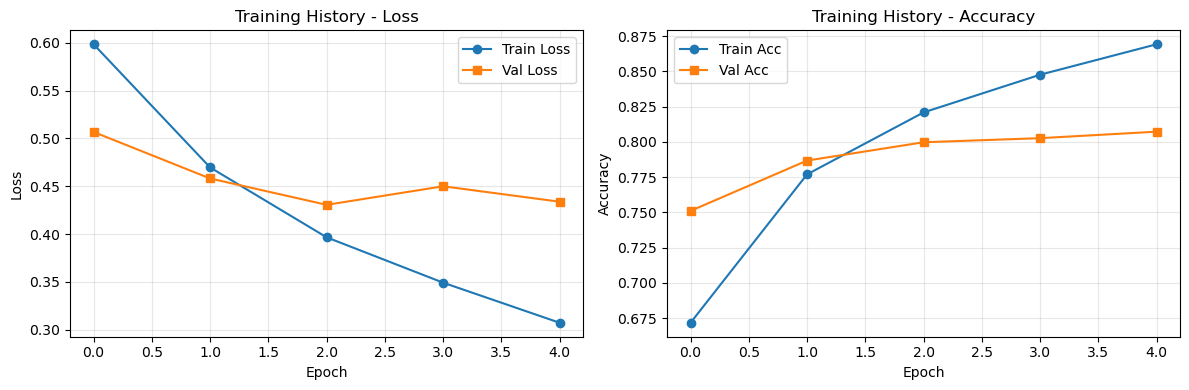

훈련 완료! 최고 성능: 0.8073
검증 정확도 80% 달성!


In [24]:
# === 실제 모델 훈련 실행 ===

print("=== 모델 훈련 실행 ===")

# 현재 데이터로 훈련 시작 (train_dataset, val_dataset이 이미 준비되어 있다고 가정)
trained_model, best_accuracy, training_history = run_training_pipeline(
    train_dataset=train_dataset,  
    val_dataset=val_dataset,      
    vocab_size=tokenizer.get_vocab_size(),
    epochs=5,        
    batch_size=32,
    learning_rate=3e-4
)

# 훈련 히스토리 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss', marker='o')
plt.plot(training_history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Acc', marker='o')
plt.plot(training_history['val_acc'], label='Val Acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History - Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"훈련 완료! 최고 성능: {best_accuracy:.4f}")
if best_accuracy >= 0.8:
    print("검증 정확도 80% 달성!")
else:
    print(f"80% 목표까지: +{0.8 - best_accuracy:.1%}")

In [25]:
# === 단계 10: 최종 테스트 평가 (ratings_test.txt 사용) ===

# 테스트 파일 경로
test_file_path = "/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/Go01/nsmc/ratings_test.txt"

# 테스트 데이터 로드
try:
    with open(test_file_path, "r", encoding="utf-8") as f:
        test_raw = f.read().splitlines()
    
    print(f"테스트 파일 로드 성공: {len(test_raw)}개 라인")
    print(f"헤더: {test_raw[0]}")
    
    # 처음 몇 개 샘플 확인
    print("\n테스트 데이터 샘플:")
    for i in range(1, 4):
        print(f"{i}: {test_raw[i]}")
        
except FileNotFoundError:
    print(f"테스트 파일을 찾을 수 없습니다: {test_file_path}")
    print("파일 경로를 확인하거나 파일이 존재하는지 확인해주세요.")
    raise
except Exception as e:
    print(f"파일 로드 중 오류: {e}")
    raise

print(f"\n독립적인 테스트 데이터 준비 완료!")

테스트 파일 로드 성공: 50001개 라인
헤더: id	document	label

테스트 데이터 샘플:
1: 6270596	굳 ㅋ	1
2: 9274899	GDNTOPCLASSINTHECLUB	0
3: 8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0

독립적인 테스트 데이터 준비 완료!


In [26]:
# === 테스트 데이터 전처리 및 정제 ===

def prepare_test_data(test_raw_data, tokenizer):
    """
    테스트 데이터를 같은 기준으로 전처리
    
    Args:
        test_raw_data: 원본 테스트 데이터
        tokenizer: 학습된 토크나이저
        
    Returns:
        test_texts, test_labels: 정제된 테스트 텍스트와 레이블
    """
    
    print("테스트 데이터 전처리 중...")
    
    raw_texts = []
    raw_labels = []
    
    # 1단계: 기본 파싱
    for line in test_raw_data[1:]:  # 헤더 제외
        try:
            parts = line.split('\t')
            if len(parts) >= 3:
                text = parts[1].strip()
                label_str = parts[2].strip()
                
                if label_str in ['0', '1'] and text:
                    raw_texts.append(text)
                    raw_labels.append(int(label_str))
        except:
            continue
    
    print(f"기본 파싱 결과: {len(raw_texts)}개")
    
    # 2단계: 훈련 데이터와 동일한 기준으로 정제
    MIN_LENGTH = 10
    MAX_LENGTH = 200
    
    clean_test_texts = []
    clean_test_labels = []
    
    for text, label in zip(raw_texts, raw_labels):
        # 길이 필터링
        if MIN_LENGTH <= len(text) <= MAX_LENGTH:
            # 품질 필터링
            korean_chars = len(re.findall(r'[가-힣]', text))
            if korean_chars >= 3:
                processed_text = tokenizer.preprocess_text(text)
                if len(processed_text.strip()) >= 5:
                    clean_test_texts.append(text)  # 원본 텍스트 저장
                    clean_test_labels.append(label)
    
    # 테스트 데이터 통계
    label_counts = Counter(clean_test_labels)
    print(f"\n정제된 테스트 데이터:")
    print(f"- 총 개수: {len(clean_test_texts)}")
    print(f"- 부정 (0): {label_counts[0]} ({label_counts[0]/len(clean_test_labels)*100:.1f}%)")
    print(f"- 긍정 (1): {label_counts[1]} ({label_counts[1]/len(clean_test_labels)*100:.1f}%)")
    
    return clean_test_texts, clean_test_labels

# 테스트 데이터 준비 실행
test_texts, test_labels = prepare_test_data(test_raw, tokenizer)

테스트 데이터 전처리 중...
기본 파싱 결과: 49997개

정제된 테스트 데이터:
- 총 개수: 45449
- 부정 (0): 22653 (49.8%)
- 긍정 (1): 22796 (50.2%)


In [31]:
# === 모델 로드 및 테스트 데이터셋 생성 ===

# 저장된 모델 확인
model_path = 'best_nsmc_model.pt'
if os.path.exists(model_path):
    # 저장된 모델 정보 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    
    print(f"저장된 모델 발견:")
    print(f"- 에포크: {checkpoint['epoch']}")
    print(f"- 검증 정확도: {checkpoint['val_acc']:.4f}")
    
    # 모델 재생성 및 가중치 로드
    final_model = SentimentClassifier(
        vocab_size=checkpoint['vocab_size'],
        embedding_dim=256,
        hidden_dim=384,
        num_classes=2,
        dropout=0.2
    ).to('cpu')
    
    final_model.load_state_dict(checkpoint['model_state_dict'])
    print("모델 가중치 로드 완료!")
    
else:
    print("저장된 모델이 없습니다. 현재 모델을 사용합니다.")
    final_model = trained_model

# 테스트 데이터셋 생성
test_dataset = NSMCDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=128,
)

# 테스트 데이터로더 생성
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n테스트 준비 완료:")
print(f"- 테스트 샘플: {len(test_dataset)}")
print(f"- 테스트 배치: {len(test_loader)}")

저장된 모델 발견:
- 에포크: 4
- 검증 정확도: 0.8073
모델 가중치 로드 완료!

테스트 준비 완료:
- 테스트 샘플: 45449
- 테스트 배치: 1421


In [33]:
# === 최종 테스트 평가 실행 ===

def final_test_evaluation(model, test_loader, device):
    """
    최종 테스트 평가 수행
    
    Returns:
        test_accuracy: 테스트 정확도
        detailed_results: 상세 결과 딕셔너리
    """
    
    print("최종 테스트 평가 시작...")
    
    model.eval()
    
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    test_losses = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        batch_count = 0
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # 예측 수행
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # 확률 및 예측 계산
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            # 결과 저장
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            test_losses.append(loss.item())
            
            batch_count += 1
            if batch_count % 10 == 0:
                print(f"  테스트 배치 {batch_count}/{len(test_loader)} 완료")
    
    # 최종 성능 계산
    test_accuracy = accuracy_score(all_true_labels, all_predictions)
    avg_test_loss = np.mean(test_losses)
    
    return test_accuracy, {
        'predictions': all_predictions,
        'true_labels': all_true_labels,
        'probabilities': all_probabilities,
        'loss': avg_test_loss
    }

# 최종 테스트 실행
print("=== ratings_test.txt 파일로 최종 평가 ===")
test_accuracy, test_results = final_test_evaluation(final_model, test_loader, 'cpu')

# 결과 발표
print(f"\n" + "="*60)
print(f"최종 테스트 결과 (ratings_test.txt)")
print(f"="*60)
print(f"테스트 정확도: {test_accuracy:.4f} ({test_accuracy:.1%})")
print(f"테스트 손실:   {test_results['loss']:.4f}")

# 목표 달성 여부
if test_accuracy >= 0.8:
    print(f"목표 달성! 80% 이상 테스트 정확도 달성")
    print(f"달성률: {test_accuracy:.1%} (목표: 80%)")
else:
    print(f"\n목표 미달성: {test_accuracy:.1%}")
    print(f"부족한 정확도: {0.8 - test_accuracy:.1%}")

# 상세 분류 리포트
print(f"\n" + "="*60)
print("상세 분류 성능 리포트")
print("="*60)
print(classification_report(
    test_results['true_labels'], 
    test_results['predictions'], 
    target_names=['부정', '긍정'],
    digits=4
))

=== ratings_test.txt 파일로 최종 평가 ===
최종 테스트 평가 시작...
  테스트 배치 10/1421 완료
  테스트 배치 20/1421 완료
  테스트 배치 30/1421 완료
  테스트 배치 40/1421 완료
  테스트 배치 50/1421 완료
  테스트 배치 60/1421 완료
  테스트 배치 70/1421 완료
  테스트 배치 80/1421 완료
  테스트 배치 90/1421 완료
  테스트 배치 100/1421 완료
  테스트 배치 110/1421 완료
  테스트 배치 120/1421 완료
  테스트 배치 130/1421 완료
  테스트 배치 140/1421 완료
  테스트 배치 150/1421 완료
  테스트 배치 160/1421 완료
  테스트 배치 170/1421 완료
  테스트 배치 180/1421 완료
  테스트 배치 190/1421 완료
  테스트 배치 200/1421 완료
  테스트 배치 210/1421 완료
  테스트 배치 220/1421 완료
  테스트 배치 230/1421 완료
  테스트 배치 240/1421 완료
  테스트 배치 250/1421 완료
  테스트 배치 260/1421 완료
  테스트 배치 270/1421 완료
  테스트 배치 280/1421 완료
  테스트 배치 290/1421 완료
  테스트 배치 300/1421 완료
  테스트 배치 310/1421 완료
  테스트 배치 320/1421 완료
  테스트 배치 330/1421 완료
  테스트 배치 340/1421 완료
  테스트 배치 350/1421 완료
  테스트 배치 360/1421 완료
  테스트 배치 370/1421 완료
  테스트 배치 380/1421 완료
  테스트 배치 390/1421 완료
  테스트 배치 400/1421 완료
  테스트 배치 410/1421 완료
  테스트 배치 420/1421 완료
  테스트 배치 430/1421 완료
  테스트 배치 440/1421 완료
  테스트 배치 450/1421 완료
  테스트 배치 460/

In [ ]:
##########회고#########
vocab size가 무조건 높다고 좋은것도 아니라는걸 배웠던것 같다 20000만 사이즈로했다가
너무 오래걸려서 15,000으로 줄여서 했는데 목표한 80점은 넘겨서 다행인것같다.
그리고 과적합이 좀 심했던 문제가 있어서 임배딩 사이즈와 모델 학습 파라미터들을 조정해가면서
과적합 문제를 어느정도는? 해결했던것 같다.
진행했던 실험 1) vocab 사이즈 조절 6000 -> 10000 -> 20000 -> 15000
         실험 2) 임배딩 사이즈 조절 256 -> 128 ( 과적합 방지)
         실험 3) dropout 및 학습률 파라미터 수정

그리고 epoch이 늘어날수록 모델이 점점 과적합된다는걸 보고
적은 epoch으로 진행